<a href="https://colab.research.google.com/github/Clement-Moreau-Info/FTH/blob/main/fuzziee_temporal_hamming_dis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [ ]:
!pip install scikit-fuzzy

import networkx as nx
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from numba import prange
from typing import List
import skfuzzy as fuzz
from scipy import signal
import numpy as np
from functools import lru_cache
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import time

     |████████████████████████████████| 1.0MB 7.5MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=b06aa63fd8b2559a13e7964c72011a1568b454d3cd09ae425478161168d231c9
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [ ]:
# Import the ontology
!wget https://gist.githubusercontent.com/Hector-Plasma/725b3cd76f89d347484e7ec21adee039/raw/48495e6f4d51d1bcfd555f03597c151beb5aa000/ontology_emd.txt -q --show-progress

ontology_emd.txt    100%[===================>]     695  --.-KB/s    in 0s      


In [ ]:
@lru_cache(maxsize=100000)
def wu_palmer(x: str, y: str, path: str, rootnode="All") -> float:
    ontologie = nx.read_adjlist(path, create_using=nx.DiGraph)
    return (2.0 * nx.shortest_path_length(ontologie, rootnode, nx.lowest_common_ancestor(ontologie, x, y))) / (
            nx.shortest_path_length(ontologie, rootnode, x) + nx.shortest_path_length(ontologie, rootnode, y))

# Path to onntology
path_onto = "ontology_emd.txt"

# Define the similarity used
def sim(x: str, y: str) -> float:
    return wu_palmer(x, y, path_onto)

# Dissimilarity index between temporal sequences

## Temporal sequences

Consider a sequence of activities $S_i=\langle (x_{i1}, \delta_{i1}), ... (x_{in}, \delta_{in})\rangle$ such that $x_{ik} \in \Sigma$, where $\Sigma$ is an alphabet  of symbols and $\delta_{ik} > 0$ represent the time duration of the symbol $x_{ik}$. 

For code simplicity, we split $S_i$ in two vectors : 

- `acts` contains the activities $x_{ik}$.
- `times` contains the time durations $\delta_{ik}$ of $x_{ik}$.

We consider formally that we have, for example, a sequence $S_1$ such that:

$S_1 = \langle$(🏡 ,210), (🚃 , 20), (🚶‍♂️, 10) (💼 , 250), (🚶‍♂️, 15), (🍽, 60), (🚃  ', 15), (💼  ', 290), (🏡 , 570)$\rangle$

encoded like this. 

In [ ]:
class Temporal_seq:
    def __init__(self, acts: List[str], times: List[float]) -> None:
        self.acts = acts
        self.times = times

In [ ]:
# Vector of x_ik
S_alice = Temporal_seq(['1', '133', '100', '11', '100', '51', '131', '12', '1'], 
                       [210,  20,    10,    250,  15,    60,   15,    290,  570])

S_bob = Temporal_seq(['1', '100', '133', '11', '100', '1'], 
                     [230,  10,   30,    480,  60, 630])

Thus, we consider $T_{\max} = 1440$, the number of minutes during a day and $I= [0, T_{\max})$.

In [ ]:
interval_step = 5

I = np.arange(0, np.sum(S_alice.times), interval_step)

## Edit Operation

Now, consider we want to modify a portion of $S_i$ by an other. Suppose we want to edit edit a new symbol $x$ for $\delta$ unit of time at the time $t_{edit}$ in the sequence $S_i$. 

Formaly, an edit operation $e$ is a 4-uplet such that:

$$e = (x, \delta, t_{edit}, S_i)$$

---
Here we want **modify by work activity 💼  (11) during 480 minutes at time 270**. 

In [ ]:
class Edit:
    def __init__(self, x: str, delta: float, t_edit: float, S_i: Temporal_seq):
        self.x = x
        self.delta = delta
        self.t_edit = t_edit
        self.S_i = S_i


e = Edit('11', 480, 270, S_alice)

We define a context function $\mu_e$, center on $t_{edit}$ and such that: $\text{Core}(\mu_e) = \{t\in I|\mu_e(t)=1\} = [t_{edit}, t_{edit} + \delta)$.

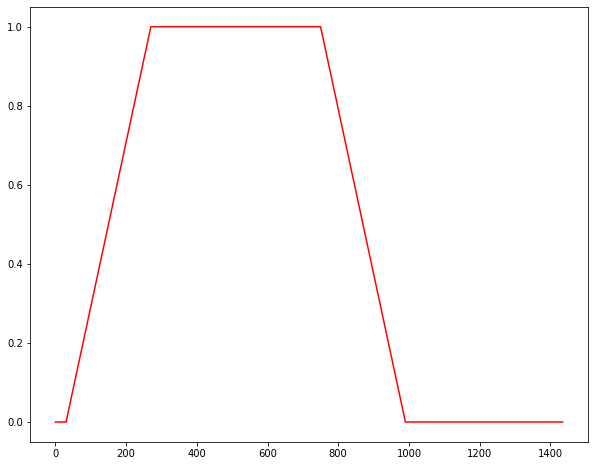

In [ ]:
# Control the gradient (here 4 hours)
time_window = 240

def fuzzy_context(e: Edit, time_window = 480) -> List[float]:
  return fuzz.trapmf(np.arange(0, np.sum(e.S_i.times), interval_step),
                     [e.t_edit - time_window, e.t_edit, e.t_edit + e.delta, e.t_edit + e.delta + time_window])

mu = fuzzy_context(e, time_window)
plt.figure(figsize=(10, 8))
plt.plot(I, mu, 'r')

Now, we plot the similarity function over the sequence,  $sim_e(t)$ which represents the similarity between $x$ and all symbols in $S_i$ for each time $t \in I$. 

Formally, $sim_e$ is defined such that : 

$$sim_S(t) = \sum_{k=1}^{n} \mathbf{1}_{I(x_{ik})}(t)\times sim(x_{ik}, x)$$

where $\mathbf{1}_A$ is the indicator function such that $\mathbf{1}_A(t)=\begin{cases}
1 & \text{if }t\in A\\
0 & \text{else}
\end{cases}$ and $I(x_{ik})$ the time interval of activity $x_{ik}$. 

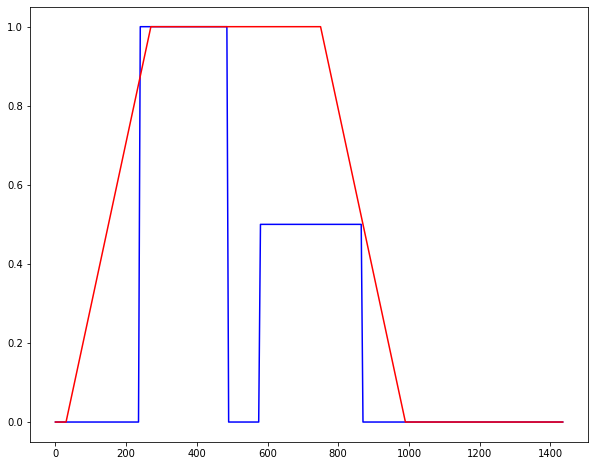

In [ ]:
def sim_e(e: Edit, t: float) -> float:
    for i in prange(len(e.S_i.times)):
        if np.sum(e.S_i.times[:i]) <= t < np.sum(e.S_i.times[:i + 1]):
            return sim(e.S_i.acts[i], e.x)
    return 0

sim_fun = [sim_e(e, t) for t in I]
plt.figure(figsize=(10, 8))
plt.plot(I, sim_fun, 'b')
plt.plot(I, mu, 'r')

At this point, we can make the fusion by a $\top$-norm of these two previous functions. 

Here, we assume that $\top(x,y) = x\times y$.

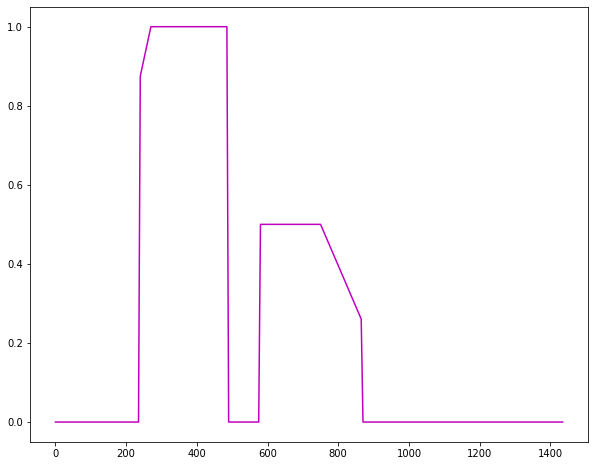

In [ ]:
sim_context = [mu[i] * sim_fun[i] for i in range(len(I))]

plt.figure(figsize=(10, 8))
plt.plot(I, sim_context, 'm')
#plt.plot(I, sim_fun, 'b')
#plt.plot(I, mu, 'r')

## Edit cost function

### Normalized $\gamma$ cost

Thanks to the previous definitions, we can developpe a function to assign a cost to an edit operator $e = (x, \delta, t_{edit}, S_i)$. 
We consider the following normalized cost function $\gamma$:

$$\gamma(e) = 1 - \sup_{\tau\in I}\left\{\int_{\tau}^{\tau+\delta} sim_e(t) \times \mu_e(t)dt\right\}$$


Formally, the cost can be view as $1 -$ the sup of the convolution function  $(sim_e(t) \times \mu_e(t)) * \mathbf{1}_{[0,\delta)}$

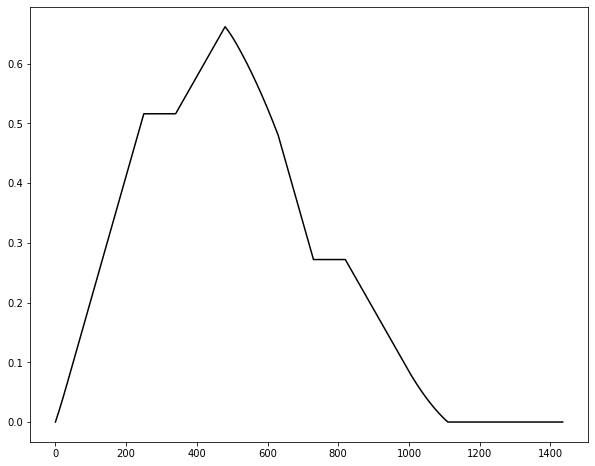

In [ ]:
tab_gate = np.arange(0, e.delta, interval_step)
gate = fuzz.trapmf(tab_gate, [0, 0, e.delta, e.delta])

convo = signal.convolve(sim_context, gate, mode='same') / (e.delta / interval_step)

plt.figure(figsize=(10, 8))
plt.plot(I, convo, 'k')

In [ ]:
print("cost = ", 1 - np.max(convo))

cost =  0.337890625


### Time-weighted $\Delta$ cost

In order to take more into accound duration, we can weight the $\gamma$ cost function by $\delta$ such that:
$$\Delta(e) = \delta \gamma(e)$$

In [ ]:
print("cost = ", e.delta * (1 - np.max(convo)))

cost =  162.1875


In [ ]:
def cost_gamma(e: Edit, interval_step = 5, time_window = 480) -> float:
  I = np.arange(0, np.sum(e.S_i.times), interval_step)
  mu = fuzz.trapmf(I, [e.t_edit - time_window, e.t_edit, e.t_edit + e.delta,
                       e.t_edit + e.delta + time_window])
  sim_fun = [sim_e(e, t) for t in I]
  sim_context = [mu[i] * sim_fun[i] for i in range(len(I))]
  tab_gate = np.arange(0, e.delta, interval_step)
  gate = fuzz.trapmf(tab_gate, [0, 0, e.delta, e.delta])
  convo = signal.convolve(sim_context, gate, mode='same') / (e.delta / interval_step)
  return 1 - np.max(convo)

def cost_delta(e: Edit, interval_step = 0.1, time_window = 4) -> float:
  return e.delta * cost_gamma(e, interval_step, time_window)

## Fuzzy dissimilarity index between temporal sequences

Finally, given two temporal sequences $S_1$ and $S_2$, we defined a one-sided dissimilarity $FTH_{S_1 \rightarrow S_2}$ from $S_1 \in \mathbb{S}^n$ to $S_2\in \mathbb{S}^p$ such that:

$$FTH_{S_1 \rightarrow S_2} = \sum_{i=1}^n f(e_i)$$

where $e_i = \left(x_{1i}, \delta_{1i}, \sum_{k=1}^{i-1}\delta_{1k}, S_2\right)$ and $f:\mathbb{E} \rightarrow \mathbb{R}^+$ a cost function e.g., $\gamma$ or $\Delta$.

In [ ]:
def one_sided_dist(S1: Temporal_seq, S2: Temporal_seq, f = cost_delta, interval_step = 5, time_window = 720) -> float:
  sum = 0
  for i in prange(len(S1.acts)):
    e = Edit(S1.acts[i], S1.times[i], np.sum(S1.times[:i]), S2)
    sum += f(e, interval_step, time_window)
  return sum

Let us compute the distance $S_{alice} \rightarrow S_{bob}$:

In [ ]:
print(one_sided_dist(S_alice, S_bob, cost_delta, 5, 240))

252.30654761904762


The reverse $S_{bob} \rightarrow S_{alice}$:

In [ ]:
print(one_sided_dist(S_bob, S_alice, cost_delta, 5, 240))

280.22321428571433


We recover the symetry thanks to a $\top$-norm operator e.g, $\max$. 

$$FTH(S_1,S_2) = \max\left\{FTH_{S_1 \rightarrow S_2}, FTH_{S_2 \rightarrow S_1}\right\}$$

In [ ]:
def dist(S1: Temporal_seq, S2: Temporal_seq, f = cost_delta, interval_step = 5, time_window = 480, agg = max)-> float:
  return agg(one_sided_dist(S1, S2, f, interval_step, time_window),
             one_sided_dist(S2, S1, f, interval_step, time_window))

# Other measures on Temporal sequences

## Hamming Distance

In [ ]:
def to_discrete(S_i: Temporal_seq, unit_of_time: float) -> List[str]:
  return [S_i.acts[k] for k in range(len(S_i.acts)) for j in range(int(S_i.times[k] / unit_of_time))]

def hamming(S1 : List[str], S2: List[str]) -> float:
  sum = 0
  for i in range(len(S1)):
    sum += 1 - sim(S1[i], S2[i])
  return sum

## DTW

In [ ]:
def dtw(seq1, seq2):
    n =  len(seq1)
    p = len(seq2)
    dtw_matrix = np.zeros((n+1, p+1))
    for i in range(n+1):
        for j in range(p+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, p+1):
            cost = 1 - sim(seq1[i-1], seq2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],
                                          dtw_matrix[i, j-1],
                                          dtw_matrix[i-1, j-1])
    return dtw_matrix[n, p]

## LCS

In [ ]:
def lcs(seq1, seq2): 
    n = len(seq1) 
    p = len(seq2) 
  
    dist = np.zeros((n + 1, p + 1))

    for i in range(n + 1): 
        for j in range(p + 1): 
            if i == 0 or j == 0 : 
                dist[i, j] = 0
            elif seq1[i-1] == seq2[j-1]: 
                dist[i, j] = dist[i-1, j-1] + 1
            else: 
                dist[i, j] = max(dist[i-1,j], dist[i,j-1]) 
    return len(seq1) + len(seq2) - 2 * dist[n, p] 

## Edit Distance

In [ ]:
def edit_dist(seq1, seq2):
    n =  len(seq1)
    p = len(seq2)
    dist = np.zeros((n + 1, p + 1))
    for i in range(n + 1):
        for j in range(p + 1):
            if i == 0 or j == 0:
                dist[i, j] = j + i
            else:
                cost = 1 - sim(seq1[i-1], seq2[j-1])
                dist[i, j] = round(min(dist[i - 1, j-1] + cost,
                                       dist[i - 1, j] + 1,
                                       dist[i, j - 1] + 1), 2)
    return dist[n, p]

# Running Example

In [ ]:
S1 = Temporal_seq(['1', '12', '131', '11', '133', '51',   '131', '100', '12','1'], 
                  [240,  60,   60,    60,  60,   90,   60, 60, 120, 630])
                
S2 = Temporal_seq(['1', '133', '11', '131', '12', '51', '100', '131', '12', '1' ], 
                  [240,  60,    60,    60,    60,   90,  60,  60,120,  630])

S3 = Temporal_seq(['1', '131', '11', '131', '11', '51', '11', '131', '11', '131', '1' ],
                  [240,  60,    60,   60,     60,     90,  60,    60,    60,    60,   630] )

S4 = Temporal_seq(['1', '131', '11', '131', '11', '51', '11', '131', '11', '131', '1' ],
                  [300,  60,    60,   60,     60,     90,  60,    60,    60,    60,   570] )

S5 = Temporal_seq(['1', '100',  '11', '51', '100', '12', '1' ],
                  [240,  60,    180,   90,    60,   180,   630] )

S6 = Temporal_seq(['1', '100', '12',  '51', '100', '12',  '1' ],
                  [330,   60,   180,    90,     60, 180,    540] )

seq_example = [S1, S2, S3, S4, S5, S6]

seq_example_discrete = [to_discrete(S, 1) for S in seq_example]

df = pd.DataFrame(seq_example_discrete) 
df.to_csv("seq_example.csv")

## Clustering

### Fuzzy Hamming ($\gamma$ cost)

In [ ]:
nb_sequences = len(seq_example)

pool = mp.Pool(mp.cpu_count())
result_gamma = pool.starmap(dist, [(seq_example[i], seq_example[j], cost_gamma) for i in range(nb_sequences) for j in range(i + 1, nb_sequences)])
pool.close()

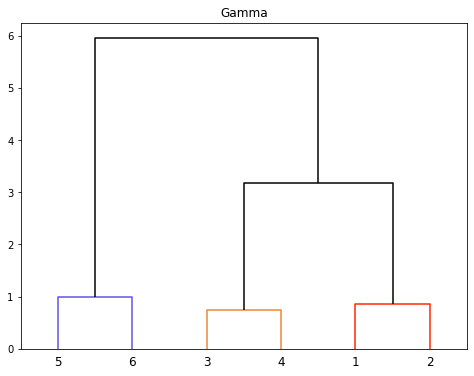

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "Gamma")

gamma_matrix = squareform(np.array(result_gamma))
gamma_csv = np.savetxt("gamma_dist.csv", gamma_matrix)

linkage_matrix = linkage(result_gamma, "ward")

hierarchy.set_link_color_palette(['#6151E6','#EE853A', '#FF2600'])

dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),
                   color_threshold=2, above_threshold_color='black')

#plt.show()
fig.savefig("gamma_dendo.pdf")

## Fuzzy Hamming ($\Delta$ cost)

In [ ]:
nb_sequences = len(seq_example)

pool = mp.Pool(mp.cpu_count())
result_delta = pool.starmap(dist, [(seq_example[i], seq_example[j]) for i in range(nb_sequences) for j in range(i + 1, nb_sequences)])
pool.close()

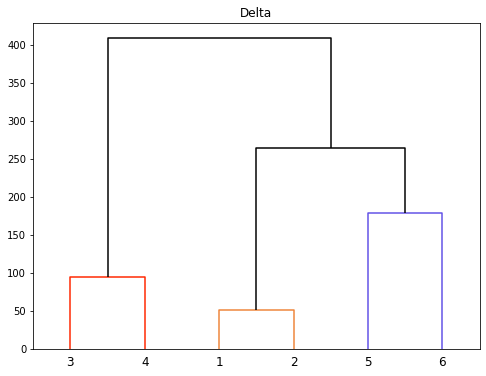

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "Delta")

linkage_matrix = linkage(result_delta, "ward")
dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),
                   color_threshold=230, above_threshold_color='black')


hierarchy.set_link_color_palette(['#FF2600', '#EE853A', '#6151E6'])

fig.savefig("delta_dendo.pdf")

delta_matrix = squareform(np.array(result_delta))
delta_csv = np.savetxt("delta_dist.csv", delta_matrix)

## Hamming 

In [ ]:
pool = mp.Pool(mp.cpu_count())
result_hamming = pool.starmap(hamming, [(seq_example_discrete[i], seq_example_discrete[j]) for i in range(nb_sequences) for j in range(i + 1, nb_sequences)])
pool.close()

hamming_matrix = squareform(np.array(result_hamming))
hamming_csv = np.savetxt("hamming_dist.csv", hamming_matrix)

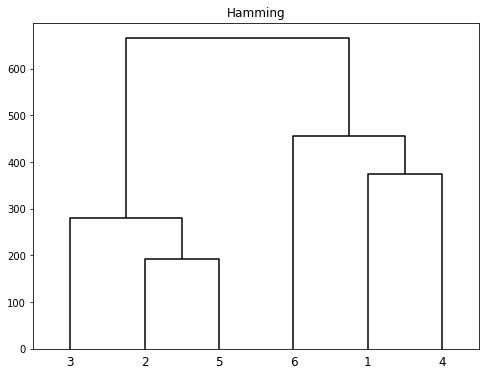

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "Hamming")

linkage_matrix = linkage(result_hamming , "ward")
dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),       
                   color_threshold=10, above_threshold_color='black')


fig.savefig("hamming_dendo.pdf")
plt.show()

## DTW

In [ ]:
pool = mp.Pool(mp.cpu_count())
result_dtw = pool.starmap(dtw, [(seq_example_discrete[i], seq_example_discrete[j]) for i in range(nb_sequences) for j in range(i + 1, nb_sequences)])
pool.close()

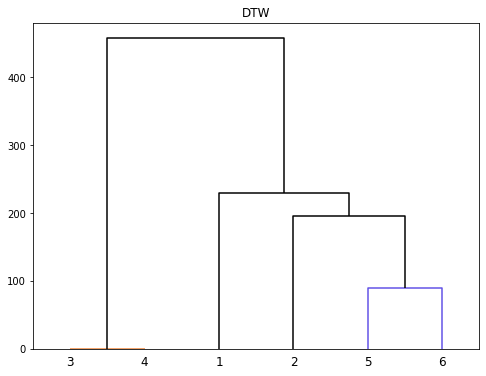

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "DTW")

linkage_matrix = linkage(result_dtw , "ward")
dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),      
                   color_threshold=100, above_threshold_color='black')

hierarchy.set_link_color_palette(['#FF2600', '#EE853A', '#6151E6'])

fig.savefig("dtw_dendo.pdf")

dtw_matrix = squareform(np.array(result_dtw))
dtw_csv = np.savetxt("dtw_dist.csv", dtw_matrix)

## Edit Distance

In [ ]:
pool = mp.Pool(mp.cpu_count())
result_edit = pool.starmap(edit_dist, [(seq_example_discrete[i], seq_example_discrete[j]) for i in range(nb_sequences) for j in range(i + 1, nb_sequences)])
pool.close()

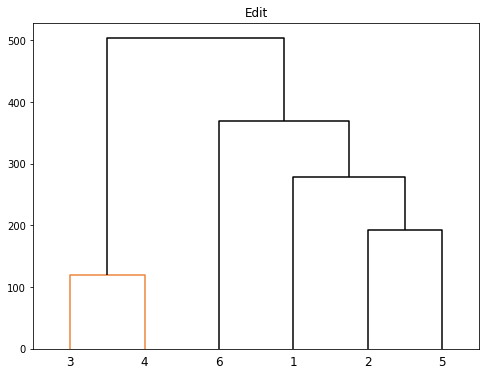

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "Edit")

linkage_matrix = linkage(result_edit , "ward")
dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),      
                   color_threshold=150, above_threshold_color='black')
hierarchy.set_link_color_palette(['#FF2600', '#EE853A', '#6151E6'])

fig.savefig("edit_dendo.pdf")

plt.show()

edit_matrix = squareform(np.array(result_edit))
edit_csv = np.savetxt("edit_dist.csv", edit_matrix)

## LCS

In [ ]:
pool = mp.Pool(mp.cpu_count())
result_lcs = pool.starmap(lcs, [(seq_example_discrete[i], seq_example_discrete[j]) for i in range(nb_sequences) for j in range(i + 1, nb_sequences)])
pool.close()

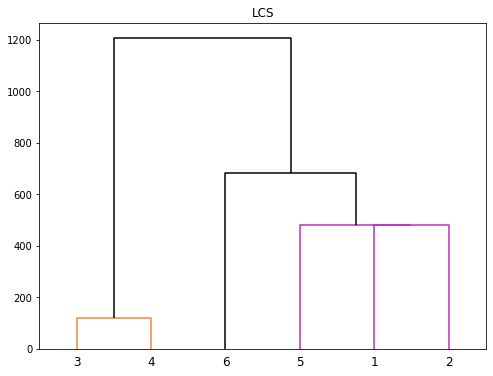

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "LCS")

linkage_matrix = linkage(result_lcs , "ward")
dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),      
                   color_threshold=600, above_threshold_color='black')
hierarchy.set_link_color_palette(['#EE853A', '#BD2CB8', '#6151E6',])

fig.savefig("lcs_dendo.pdf")
lcs_matrix = squareform(np.array(result_lcs))
lcs_csv = np.savetxt("lcs_dist.csv", lcs_matrix)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


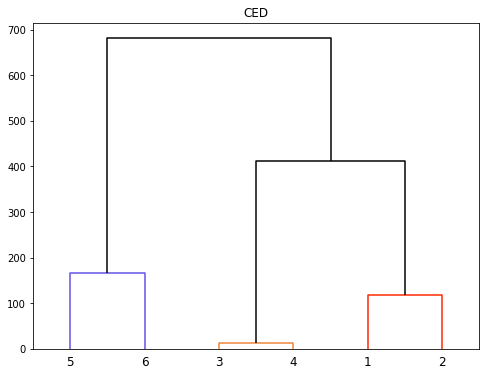

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "CED")

ced_dist = np.loadtxt("ced_dist.csv", delimiter=" ")
linkage_matrix = linkage(ced_dist , "ward")
dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),      
                   color_threshold=300, above_threshold_color='black')

hierarchy.set_link_color_palette(['#6151E6', '#EE853A', '#FF2600'])

fig.savefig("ced_dendo.pdf")

# Sankey Diagram

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["H1", "H2", "H3", "H4", "H5", "F1", "F2", "F3", "F4", "F5"],
      color = "blue"
    ),
    link = dict(
      source = [0, 0, 0, 0, 0,    1, 1, 1, 1, 1,    2, 2, 2, 2, 2,   3, 3, 3, 3, 3,     4, 4, 4, 4, 4], 
      target = [5, 6, 7, 8, 9,    5, 6, 7, 8, 9,    5, 6, 7, 8, 9,   5, 6, 7, 8, 9,     5, 6, 7, 8, 9],
      value = [184, 2, 0, 0, 0,  46, 509, 1, 47, 4,  0, 0, 54, 3, 0,  0, 0, 6, 327, 0,  0, 0, 0, 0 ,17]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["H1", "H2", "H3", "H4", "H5", "FTHΔ-1", "FTHΔ-2", "FTHΔ-3", "FTHΔ-4", "FTHΔ-5",
               "FTHγ-1", "FTHγ-2", "FTHγ-3", "FTHγ-4", "FTHγ-5"],
      color = "blue"
    ),
    link = dict(
      source = [0, 0, 0, 0, 0,    1, 1, 1, 1, 1,       2, 2, 2, 2, 2,     3, 3, 3, 3, 3,         4, 4, 4, 4, 4,
                5, 5, 5, 5, 5,    6, 6, 6, 6, 6,       7, 7, 7, 7, 7,     8, 8, 8, 8, 8,         9, 9, 9, 9, 9], 
      target = [5, 6, 7, 8, 9,    5, 6, 7, 8, 9,        5, 6, 7, 8, 9,     5, 6, 7, 8, 9,        5, 6, 7, 8, 9,
              10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14, 10, 11, 12, 13, 14],
      value = [184, 2, 0, 0, 0,  46, 509, 1, 47, 4,  0, 0, 54, 3, 0,  0, 0, 6, 327, 0,  0, 0, 0, 0 ,17,
               74, 56, 1, 96, 3,  56, 174, 5, 208, 68, 6, 9, 30, 11, 5, 43, 55, 136, 127, 16, 4, 7, 6, 4, 0]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()
